In [1]:
#Recreating a simple DQN with PyTorch

In [2]:
import gym
import random
import numpy as np

from collections import deque

import torch
from torch import Tensor
import torch.optim as optim
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [3]:
BATCH_SIZE = 32
ENV_NAME = "CartPole-v0"
USE_CUDA = torch.cuda.is_available()
GAMMA = .99

In [4]:
def Variable(*args, **kwargs):
    if USE_CUDA:
        return autograd.Variable(*args, **kwargs).cuda()
    else:
        return autograd.Variable(*args, **kwargs)

In [5]:
env = gym.make(ENV_NAME)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [28]:
class DQN(nn.Module):
    def __init__(self, env, num_extra_dense = 1):
        super(DQN, self).__init__()
        
        self.input_shape = env.observation_space.shape[0]
        self.output_shape = env.action_space.n
        
        layers = [nn.Linear(self.input_shape, 64 * 2 ** num_extra_dense),
            nn.LeakyReLU(),
            #nn.Dropout(.2),
            #nn.BatchNorm2d(64 * 2 ** num_extra_dense)
                 ]
        
        for i in range(num_extra_dense, 0, -1):
            layers.extend([
                nn.Linear(64 * 2 ** i, 64 * 2 ** (i - 1)),
                nn.LeakyReLU(),
                #nn.Dropout(.2),
                #nn.BatchNorm2d(64 * 2 ** (i - 1)) 
            ])
            
        layers.append(nn.Linear(64, self.output_shape))
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)
    
    def get_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(0, self.output_shape)
        else:
            self.eval()
            predictions = self(state)
            self.train()
            return int(predictions.data.numpy().argmax())

In [29]:
def pass_weights(origin, destination):
    destination.load_state_dict(origin.state_dict())

In [30]:
current_network = DQN(env)
target_network = DQN(env)

if USE_CUDA:
    current_network = current_network.cuda()
    target_network = target_network.cuda()
    
pass_weights(current_network, target_network)
current_network

DQN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): LeakyReLU(0.01)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(0.01)
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [31]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen = capacity)
        
    def add(self, data):
        self.buffer.append(data)
    
    def sample(self, n = BATCH_SIZE):
        length = len(self.buffer)
        return [self.buffer[random.randrange(length)] for _ in range(n)]

    def __len__(self):
        return len(self.buffer)

In [32]:
from IPython.display import clear_output
def plot_progress(rewards):
    clear_output(True)
    plt.figure(figsize = (12, 4))
    plt.subplot(111)
    plt.title("Rewards")
    plt.plot(rewards)
    plt.show()

In [33]:
optimizer = optim.Adam(current_network.parameters())

Loss function from https://danieltakeshi.github.io/2016/12/01/going-deeper-into-reinforcement-learning-understanding-dqn/

\begin{align}
L(\theta) &= \mathbb{E}_{(s,a,r,s')}\left[\frac{1}{2}({\rm Bellman} - Q(s,a;\theta))^2\right] \\
&=
\mathbb{E}_{(s,a,r,s')}\left[\frac{1}{2}\left(R(s,a,s')+\gamma\max_{a'}Q(s',a';\theta) - Q(s,a;\theta)\right)^2\right]
\end{align}

In [34]:
def train():
    samples = buffer.sample(BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*samples)

    states = Variable(Tensor(np.stack(states)))
    next_states = Variable(Tensor(np.stack(next_states)))
    actions = Variable(torch.LongTensor(actions))
    rewards = Variable(Tensor(rewards))
    dones = Variable(Tensor(dones))

    q_values = current_network(states)
    next_q_values = current_network(next_states)
    next_q_values_target = target_network(next_states)

    q_values_chosen_action = q_values.gather(1, actions.unsqueeze(1))
    q_values_best_next_action = next_q_values.gather(1, next_q_values_target.max(1)[1].unsqueeze(1))

    expected_q_value = rewards + GAMMA * q_values_best_next_action.squeeze() * (1 - dones)
    
    loss = F.smooth_l1_loss(q_values_chosen_action, Variable(expected_q_value.data))

    optimizer.zero_grad()
    loss.backward()
    
    for param in current_network.parameters():
        param.grad.data.clamp_(-1, 1)
    
    optimizer.step()

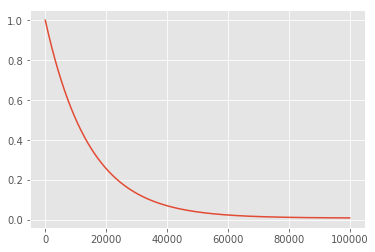

In [35]:
epsilon_end = .01
epsilon_start = 1
decay_period = 10000
def epsilon_decay(i):
    return epsilon_end + (epsilon_start - epsilon_end) * .5 ** (i / decay_period)

plt.plot([epsilon_decay(i) for i in range(100000)])

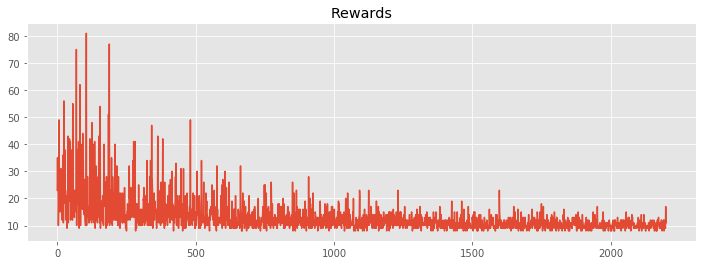

KeyboardInterrupt: 

In [36]:
buffer = ReplayBuffer(1000)

rewards = []
i = 0
for game in range(1,10001):
    done = False
    state = env.reset()
    total_reward = 0
    while not done:
        i += 1
        preprocessed = Variable(Tensor(state[None, ...]))
        action = current_network.get_action(preprocessed, epsilon_decay(i))
        
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        data = (state, action, reward, next_state, done)
        buffer.add(data)
        
        state = next_state
        
        if len(buffer) > BATCH_SIZE:
            train()
        
        if i % 10000 == 0:
            pass_weights(current_network, target_network)
    
    rewards.append(total_reward)
    if game % 100 == 0:
        plot_progress(rewards)

In [ ]:
from collections import Counter
Counter([buffer.buffer[i][1] for i in range(len(buffer))])

In [ ]:
epsilon_decay(i)

In [ ]:
i